<a href="https://colab.research.google.com/github/nagusubra/Solar_panel_dust_detection/blob/main/Solar_panel_dust_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries and modules

In [1]:
!pip install -q tensorflow-model-optimization
!pip install openpyxl
!pip install xlsxwriter

import xlsxwriter
import openpyxl
from openpyxl import Workbook
from openpyxl.drawing.image import Image

import tempfile
from tensorflow import keras
import tensorflow_model_optimization as tfmot

from tqdm import tqdm_notebook as tqdm
import os
import time
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 2.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import cross_val_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

import os
import zipfile

In [3]:
# mounting google drive (if you are using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# from os import listdir
# from os.path import isfile, join

# mypath = '/content/drive/MyDrive/Solar_panel_dust_detection/dataset_2/dirty'

# onlyfiles = [ f  for f in listdir(mypath) if isfile(join(mypath, f))]

# onlyfiles

In [5]:
# from os import listdir
# from os.path import isfile, join

# mypath = '/content/drive/MyDrive/Solar_panel_dust_detection/dataset_2/dirty'

# onlyfiles = [ os.rename(join(mypath, f), join(mypath, f.split(".")[0] + "_dirty" + ".jpg"))  for f in listdir(mypath) if isfile(join(mypath, f))]

# onlyfiles

# Evaluation function

In [6]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)
  return os.path.getsize(zipped_file)

def evaluate_model(model_path, model_info, val_dataset):

  # Evaluate test accuracy and test loss
  model = tf.keras.models.load_model(model_path)
  test_loss, test_acc = model.evaluate(val_dataset, verbose=0)

  # Evaluate Model Size
  model_size = get_gzipped_model_size(model_path)

  # Evaluate Inference Time
  startTime = time.time()
  prediction = model.predict(val_dataset)
  executionTime = (time.time() - startTime)/len(val_dataset)

  # Print
  print('\nModel Accuracy:', test_acc*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is: ", executionTime, "s")

  # Build Evalution dataframe
  evulation_dict = {
                      "Evaluation type": "Evualation",
                      "Model Information": model_info,
                      "Accuracy": str(test_acc*100) + " %",
                      "Loss": str(test_loss*100) + " %",
                      "Model Size": str(model_size) + " bytes",
                      "Inference Time": str(executionTime) + " sec"
                    }
  
  evulation_df = pd.DataFrame.from_dict(evulation_dict, orient='index').reset_index()


  return test_acc, model_size, executionTime, evulation_df

# Build base model

In [7]:
def SolNet(in_size):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)
  SolNet = Model(i, o)
  SolNet.save('models/solnet.hdf5')
  SolNet.save('models/solnet.h5')

  SolNet.compile(optimizer=Adam(.0001, .8, .9), loss=binary_crossentropy, metrics=['acc'])
  SolNet.summary()
  return SolNet

#Base Model

In [ ]:
def SolNet(in_size):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)
  SolNet = Model(i, o)
  # SolNet.save('models/solnet.hdf5')
  # SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet'+str(datetime.datetime.today().date())+'.hdf5')
  SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet'+str(datetime.datetime.today().date())+'.h5')
  SolNet.compile(optimizer=Adam(.0001, .8, .9), loss=binary_crossentropy, metrics=['acc'])
  SolNet.summary()
  return SolNet

In [8]:
def evaluate():
  path = "/content/models/solnet.hdf5"
  solnet = load_model(path, compile=False)
  # history = solnet.history()
  plt.plot(history.history['loss'])
  plt.plot(history.history['acc'])
  plt.title('acc loss vs epoch')
  plt.xlabel('epoch')
  plt.legend(['loss', 'acc'], loc='upper left')
  plt.show()

In [9]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [10]:
# # base model

# batch_size = 32
# #location = 'dataset/'
# location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"
# label_mode = 'binary'
# seed = 10 #changed for each fold made manually
# epochs=30
# #epochs=5


# class_names = ['clean', 'dirty']
# in_size = [227, 227, 3]

# tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
#                                           seed=seed, labels='inferred', image_size=in_size[:-1], 
#                                           subset = 'training', batch_size=batch_size, validation_split=.2)

# val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
#                                           seed=seed, labels='inferred', image_size=in_size[:-1],
#                                           subset = 'validation', batch_size=batch_size, validation_split=.2)

# in_size = [227, 227, 3]
# SolNet = SolNet(in_size)



# startTime = time.time()
# history = SolNet.fit(tr_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)
# executionTime = (time.time() - startTime)

In [ ]:
# print(history.history)

In [ ]:
# evaluate()

In [11]:
# plt.plot(history.history['acc'], label='accuracy')
# plt.plot(history.history['val_acc'], label = 'val_accuracy')
# plt.title('model accuracy plot')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss plot')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='best')
# plt.show()

In [ ]:
# print("Inference Time is", executionTime/60, "mins")

# Updated Solnet model

In [ ]:
def SolNet_updated(in_size, learning_rate, model_path):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)


  SolNet = Model(inputs = i, outputs = o)



  # SolNet.save('models/solnet.hdf5')
  # SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+str(datetime.datetime.today().date())+'.hdf5')
  SolNet.compile(optimizer=Adam(learning_rate), loss=binary_crossentropy, metrics=['acc'])
  SolNet.save(model_path)
  SolNet.summary()
  return SolNet

In [ ]:
# model_path = '/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+ str(datetime.datetime.today().date()) + '.h5'
# model_plot_path = '/content/drive/MyDrive/Solar_panel_dust_detection/plots/'+ str(datetime.datetime.today().date())
# model_excel_file_path = '/content/drive/MyDrive/Solar_panel_dust_detection/evaluation/'+ str(datetime.datetime.today().date())
# location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"

# batch_size = 32
# label_mode = 'binary'
# seed = 10 #changed for each fold made manually
# epochs= 2
# in_size = [227, 227, 3]

# class_names = ['clean', 'dirty']
# test_labels = class_names

# tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
#                                           seed=seed, labels='inferred', image_size=in_size[:-1], 
#                                           subset = 'training', batch_size=batch_size, validation_split=.2)

# val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
#                                           seed=seed, labels='inferred', image_size=in_size[:-1],
#                                           subset = 'validation', batch_size=batch_size, validation_split=.2)

# # in_size = [227, 227, 3]
# SolNet_model = SolNet_updated(in_size, 0.00001, model_path)



# startTime = time.time()
# history = SolNet_model.fit(tr_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)
# executionTime = (time.time() - startTime)

In [ ]:
# model_info = "batch_size: " + str(batch_size) + " and epochs: " + str(epochs) + " and in_size: " + str(in_size)
# print(model_info)
# print("Inference Time is", executionTime/60, "mins")

In [ ]:
# plt.plot(history.history['acc'], label='accuracy')
# plt.plot(history.history['val_acc'], label = 'val_accuracy')
# plt.title('model accuracy plot')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')
# plt.savefig(model_plot_path + '_model_accuracy_plot.png')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss plot')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='best')
# plt.savefig(model_plot_path + '_model_loss_plot.png')
# plt.show()

In [ ]:
# # Evaluate Inference Time
# startTime = time.time()
# model = tf.keras.models.load_model(model_path)
# test_loss, test_acc = model.evaluate(val_dataset, verbose=0)
# prediction = model.predict(val_dataset)
# executionTime = (time.time() - startTime)/len(val_dataset)
# print(executionTime)
# print(test_acc)

In [ ]:
# test_acc, model_size, executionTime, evulation_df = evaluate_model(model_path, model_info, val_dataset)

In [ ]:
# evulation_df

In [ ]:
# path = model_excel_file_path + '_model_evaluation.xlsx'

# with pd.ExcelWriter(path) as writer:
#   # writer.book = openpyxl.load_workbook(path)
#   evulation_df.to_excel(writer, sheet_name='Model_evaluation')
#   pd.DataFrame().to_excel(writer, sheet_name='Plots')
  

#   worksheet = writer.sheets['Plots']
#   worksheet.insert_image('A1', model_plot_path + '_model_accuracy_plot.png')
#   worksheet.insert_image('K1', model_plot_path + '_model_loss_plot.png')
#   writer.save()

#Loop based hyperparameter optimization

In [ ]:
def SolNet_updated_for_loop(in_size, learning_rate, model_path):
  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)


  SolNet = Model(inputs = i, outputs = o)



  # SolNet.save('models/solnet.hdf5')
  # SolNet.save('/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+str(datetime.datetime.today().date())+'.hdf5')
  SolNet.compile(optimizer=Adam(learning_rate), loss=binary_crossentropy, metrics=['acc'])
  SolNet.save(model_path)
  SolNet.summary()
  return SolNet

In [ ]:
def plot_history(history, model_plot_path, iteration_number):
  
  model_accuracy_plot_modified = model_plot_path + "_model_iteration_" + str(iteration_number) + "_model_accuracy_plot.png"
  model_loss_plot_modified = model_plot_path + "_model_iteration_" + str(iteration_number) + "_model_loss_plot.png"
  
  plt.plot(history.history['acc'], label='accuracy')
  plt.plot(history.history['val_acc'], label = 'val_accuracy')
  plt.title('model accuracy plot')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  
  plt.savefig(model_accuracy_plot_modified)
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss plot')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.savefig(model_loss_plot_modified)
  plt.show()

  return model_accuracy_plot_modified, model_loss_plot_modified

In [ ]:
def save_execution_trial(evluation_df, model_excel_file_path, model_accuracy_plot_modified, model_loss_plot_modified, iteration_number):
  path = model_excel_file_path + "_model_iteration_" + str(iteration_number) + '_model_evaluation.xlsx'

  with pd.ExcelWriter(path) as writer:
    # writer.book = openpyxl.load_workbook(path)
    evluation_df.to_excel(writer, sheet_name='Model_evaluation')
    pd.DataFrame().to_excel(writer, sheet_name='Plots')
    

    worksheet = writer.sheets['Plots']
    worksheet.insert_image('A1', model_accuracy_plot_modified)
    worksheet.insert_image('K1', model_loss_plot_modified)
    writer.save()

Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.
The model info:  batch_size: 32 and epochs: 10 and in_size: [227, 227, 3] and lr: 1e-06
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                          

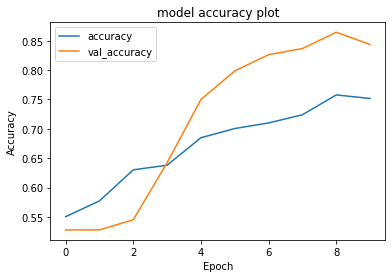

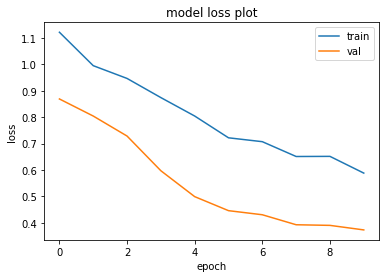

9/9 [==============================] - 23s 34ms/step

Model Accuracy: 52.77777910232544 %
Model Size: 212499452.00 bytes
Inference Time is:  2.5659365124172635 s
The evaluation df: 
                index                                                  0
0    Evaluation type                                         Evualation
1  Model Information  batch_size: 32 and epochs: 10 and in_size: [22...
2           Accuracy                                52.77777910232544 %
3               Loss                               118.23338270187378 %
4         Model Size                                    212499452 bytes
5     Inference Time                             2.5659365124172635 sec 



/usr/local/lib/python3.9/dist-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.
The model info:  batch_size: 32 and epochs: 30 and in_size: [227, 227, 3] and lr: 1e-06
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                        

In [ ]:
model_path = '/content/drive/MyDrive/Solar_panel_dust_detection/models/solnet_updated_'+ str(datetime.datetime.today().date())
model_plot_path = '/content/drive/MyDrive/Solar_panel_dust_detection/plots/'+ str(datetime.datetime.today().date())
model_excel_file_path = '/content/drive/MyDrive/Solar_panel_dust_detection/evaluation/'+ str(datetime.datetime.today().date())
location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"



# loop_dict = {
#               # index: [ bs, epoch, lr]
#               1:       [ 32, 10,    0.0001  ],
#               2:       [ 32, 10,    0.00001 ],
#               3:       [ 32, 20,    0.0001  ],
#               4:       [ 32, 20,    0.00001 ],
#               5:       [ 64, 10,    0.0001  ],
#               6:       [ 64, 10,    0.00001 ],
#               7:       [ 64, 20,    0.0001  ],
#               8:       [ 64, 20,    0.00001 ],
# }


# loop_dict = {
#               # index: [ bs, epoch, lr]
#               # 11:       [ 32, 10,    0.0001  ],
#               12:       [ 32, 10,    0.00001 ],
#               # 13:       [ 32, 20,    0.0001  ],
#               14:       [ 32, 20,    0.00001 ],
#               # 15:       [ 64, 10,    0.0001  ],
#               16:       [ 64, 10,    0.00001 ],
#               # 17:       [ 64, 20,    0.0001  ],
#               18:       [ 64, 20,    0.00001 ],
# }

loop_dict = {
              # index: [ bs, epoch, lr]
              # 21:       [ 32, 10,    0.0001  ],
              22:       [ 32, 10,    0.000001 ],
              # 23:       [ 32, 20,    0.0001  ],
              24:       [ 32, 30,    0.000001 ],
              # 25:       [ 64, 10,    0.0001  ],
              26:       [ 64, 30,    0.000001 ],
              # 27:       [ 64, 20,    0.0001  ],
              28:       [ 64, 30,    0.000001 ],
}




# # batch_sizes = [16,32,64,128]
# batch_sizes = [32,64]

# # epoch_list = [10, 15, 20, 30]
# epoch_list = [10, 20]

# # learning_rates = [0.001, 0.0001 , 0.00001, 0.000001]
# learning_rates = [0.0001 , 0.00001]

# # in_sizes =  [
# #                 [100, 100, 3],
# #                 [136, 136, 3],
# #                 [204, 204, 3],
# #                 [227, 227, 3],
# #             ]

# in_sizes =  [
#                 [136, 136, 3], #insize_1
#                 [227, 227, 3], #insize_2
#             ]

in_sizes_dict =  {
                      # 1: [136, 136, 3], #insize_1
                      2: [227, 227, 3], #insize_2
          
}
               
            

label_mode = 'binary'
seed = 10 #changed for each fold made manually
class_names = ['clean', 'dirty']

# cnt = 0
# for batch_size in batch_sizes:
#   for epoch in epoch_list:
#     for learning_rate in learning_rates:
#       for in_size in in_sizes:

#         tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
#                                           seed=seed, labels='inferred', image_size=in_size[:-1], 
#                                           subset = 'training', batch_size=batch_size, validation_split=.2)

#         val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
#                                                   seed=seed, labels='inferred', image_size=in_size[:-1],
#                                                   subset = 'validation', batch_size=batch_size, validation_split=.2)
        
#         model_path_modified = model_path + "_model_iteration_" + str(cnt) + ".h5"
#         model_info = "batch_size: " + str(batch_size) + " and epochs: " + str(epoch) + " and in_size: " + str(in_size) + " and lr: " + str(learning_rate)
#         print("The model info: ", model_info)

#         SolNet_model = SolNet_updated_for_loop(in_size, learning_rate, model_path_modified)
        
#         history = SolNet_model.fit(tr_dataset, validation_data=val_dataset, epochs=epoch, batch_size=batch_size)
#         model_accuracy_plot_modified, model_loss_plot_modified = plot_history(history, model_plot_path, cnt)

#         test_acc, model_size, executionTime, evluation_df = evaluate_model(model_path_modified, model_info, val_dataset)
#         print("The evaluation df: \n", evluation_df, "\n")

#         save_execution_trial(evluation_df, model_excel_file_path, model_accuracy_plot_modified, model_loss_plot_modified, cnt)

#         cnt += 1




# cnt = 0



for key_1, value_1 in in_sizes_dict.items():

  cnt_1 = key_1
  in_size = value_1

  for key, value in loop_dict.items():

    cnt = key
    batch_size, epoch, learning_rate = value

    tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                      seed=seed, labels='inferred', image_size=in_size[:-1], 
                                      subset = 'training', batch_size=batch_size, validation_split=.2)

    val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                              seed=seed, labels='inferred', image_size=in_size[:-1],
                                              subset = 'validation', batch_size=batch_size, validation_split=.2)
    
    model_path_modified = model_path + "_model_iteration_" + str(cnt) + "__size_iteration_" + str(cnt_1) + ".h5"
    model_info = "batch_size: " + str(batch_size) + " and epochs: " + str(epoch) + " and in_size: " + str(in_size) + " and lr: " + str(learning_rate)
    print("The model info: ", model_info)

    SolNet_model = SolNet_updated_for_loop(in_size, learning_rate, model_path_modified)
    
    history = SolNet_model.fit(tr_dataset, validation_data=val_dataset, epochs=epoch, batch_size=batch_size)
    model_accuracy_plot_modified, model_loss_plot_modified = plot_history(history, model_plot_path, cnt)

    test_acc, model_size, executionTime, evluation_df = evaluate_model(model_path_modified, model_info, val_dataset)
    print("The evaluation df: \n", evluation_df, "\n")

    save_execution_trial(evluation_df, model_excel_file_path, model_accuracy_plot_modified, model_loss_plot_modified, str(cnt) + "__size_iteration_" + str(cnt_1) )

    # cnt += 1

# Final base model

In [18]:
def evaluate_model_without_saving_stats(model, model_path, model_info, val_dataset):

  # Evaluate test accuracy and test loss
  # model = tf.keras.models.load_model(model_path)
  test_loss, test_acc = model.evaluate(val_dataset, verbose=0)

  # Evaluate Model Size
  model_size = get_gzipped_model_size(model_path)

  # Evaluate Inference Time
  startTime = time.time()
  prediction = model.predict(val_dataset)
  executionTime = (time.time() - startTime)/len(val_dataset)

  # Print
  print('\nModel Accuracy:', test_acc*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is: ", executionTime, "s")

  # Build Evalution dataframe
  evulation_dict = {
                      "Evaluation type": "Evualation",
                      "Model Information": model_info,
                      "Accuracy": str(test_acc*100) + " %",
                      "Loss": str(test_loss*100) + " %",
                      "Model Size": str(model_size) + " bytes",
                      "Inference Time": str(executionTime) + " sec"
                    }
  
  evulation_df = pd.DataFrame.from_dict(evulation_dict, orient='index').reset_index()


  return test_acc, model_size, executionTime, evulation_df

In [19]:
def SolNet_final_base_model(in_size):

  i = Input(in_size)
  r = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(i)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(r)
  r = BatchNormalization()(r)
  r = MaxPooling2D(pool_size=(3,3), strides=(2,2))(r)
  r = Flatten()(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  r = Dense(4096, activation='relu')(r)
  r = Dropout(0.5)(r)
  o = Dense(1, activation='sigmoid')(r)
  SolNet = Model(i, o)

  # SolNet.save('models/solnet.hdf5') # don't have to sabe the model before training
  # SolNet.save('models/solnet.h5')   # don't have to sabe the model before training

  #  SolNet.compile(optimizer=Adam(.0001, .8, .9), loss=binary_crossentropy, metrics=['acc'])
  SolNet.compile(optimizer=Adam(.00001), loss=binary_crossentropy, metrics=['acc']) # no beta parameters and with 10^-5 as lr
  SolNet.summary()

  return SolNet

In [21]:
batch_size = 32
location = "/content/drive/MyDrive/Solar_panel_dust_detection/dataset_1"
label_mode = 'binary'
seed = 10 #changed for each fold made manually
epochs = 40
class_names = ['clean', 'dirty']
in_size = [227, 227, 3]

tr_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1], 
                                          subset = 'training', batch_size=batch_size, validation_split=.2)

val_dataset = image_dataset_from_directory(directory=location, label_mode= label_mode, class_names=class_names,
                                          seed=seed, labels='inferred', image_size=in_size[:-1],
                                          subset = 'validation', batch_size=batch_size, validation_split=.2)

final_base_model = SolNet_final_base_model(in_size = [227, 227, 3])
history = final_base_model.fit(tr_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size)

Found 1440 files belonging to 2 classes.
Using 1152 files for training.
Found 1440 files belonging to 2 classes.
Using 288 files for validation.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 25

In [22]:
final_base_model.save('final_base_model.h5')

In [23]:
test_acc, model_size, executionTime, evulation_df = evaluate_model_without_saving_stats(final_base_model, 'final_base_model.h5', "#1", val_dataset)
display(evulation_df)

9/9 [==============================] - 22s 35ms/step

Model Accuracy: 96.18055820465088 %
Model Size: 648760098.00 bytes
Inference Time is:  2.435709900326199 s


,index,0
0,Evaluation type,Evualation
1,Model Information,#1
2,Accuracy,96.18055820465088 %
3,Loss,11.30877211689949 %
4,Model Size,648760098 bytes
5,Inference Time,2.435709900326199 sec


In [27]:
final_base_model.save('/content/drive/MyDrive/Solar_panel_dust_detection/final_base_model/final_base_model.h5')